# Visualize various metrics

This notebook provides an example of looking at different metrics to identify effects of different events (e.g. stay at home orders, outlier deaths, etc.)

Make sure to run batch model fitting to generate `data/metro_areas.csv` before running this notebook.

```
python fit_models.py --specfile=metro_areas
```

In [1]:
import itertools
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import ndimage, optimize, signal
import statsmodels.api as sm
import os
import pickle
import requests
from scipy.interpolate import make_interp_spline, BSpline
from time import mktime
from scipy import ndimage

from modeling import dataproc, sir_model


# Utility functions

In [2]:
def plot_sir_model(r, i, total_model_days, df, metric, sampling_rate, name):
    """Plot the model death rates and total deaths vs actual data.
    
    Args:
        r: Array holding daily recovered population values from SIR model
        i: Array holding daily infected population values from SIR model
        total_model_days: Total number of modeled days to plot
        df: Dataframe holding metric values.
        metric: The type of metric to plot ('Cases' or 'Deaths')
        sampling_rate: Number of samples per day used to simulate the model.
        name: A name to attach to the plot.
    """
    plot_start_time = df['Date'].min().timestamp()
    plot_step_size = 24 * 60 * 60 / sampling_rate
    plot_end_time = plot_start_time + total_model_days * 24 * 60 * 60 
    plot_timestamps = np.arange(plot_start_time, plot_end_time, plot_step_size)
    plot_dates = [datetime.utcfromtimestamp(x) for x in plot_timestamps]
    print('peak date', plot_dates[np.argmax(i)])
    # Plot peak infection
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates[:-sampling_rate],
            (r[sampling_rate:] - r[:-sampling_rate]),
            c='g',
            label='model ' + metric + ' rate',
            linewidth=4)
    ax.plot(df['Date'].to_list()[:-1],
            (df[metric] - df[metric].shift())[1:], label='actual ' + metric + ' rate', c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.plot()
    
    # Plot recovery
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates, r, c='g',
            label='model ' + metric, linewidth=4)
    ax.plot(df['Date'].to_list(), df[metric], label='actual ' + metric, c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.show()

# Load Covid-19 and Census Data

In [3]:
datastore = dataproc.DataStore()

In [97]:
fips_df = datastore.county_census_df[['STATE', 'STNAME']].groupby('STNAME').mean()
fips_df

,STATE
STNAME,
Alabama,1
Alaska,2
Arizona,4
Arkansas,5
California,6
Colorado,8
Connecticut,9
Delaware,10
District of Columbia,11


In [128]:
# Get top 10 weekly deaths
MODEL_FIT_LAST_DATE = datetime(2020, 6, 23)
TOP_K = 10

pop_df = datastore.us_combined_df[['Date', 'STNAME', 'POPESTIMATE2019']].groupby(['Date','STNAME']).sum()
pop_df = datastore.county_census_df
pop_df = pop_df[pop_df['COUNTY'] == 0]
pop_df = pop_df[['STNAME', 'POPESTIMATE2019']]
pop_df = pop_df.set_index('STNAME')

deaths_df = datastore.us_combined_df[['Date', 'Deaths', 'STNAME']]
deaths_df = deaths_df[deaths_df['Deaths'] >= 1]
deaths_df = deaths_df.join(pop_df, on='STNAME')
deaths_df['Deaths'] = deaths_df['Deaths'] / deaths_df['POPESTIMATE2019']
#deaths_df = deaths_df.join(fips_df, on='STNAME')
del deaths_df['POPESTIMATE2019']
deaths_df = deaths_df.groupby(['Date', 'STNAME']).sum()

curr_deaths = deaths_df[deaths_df.index.get_level_values(0) == MODEL_FIT_LAST_DATE]
curr_deaths.index = curr_deaths.index.droplevel(0)
last_week_deaths = deaths_df[deaths_df.index.get_level_values(0) == MODEL_FIT_LAST_DATE - timedelta(7)]
last_week_deaths.index = last_week_deaths.index.droplevel(0)
top_k_deaths = (curr_deaths - last_week_deaths).sort_values('Deaths', ascending=False)[:TOP_K]
top_k_deaths = top_k_deaths.join(fips_df, on='STNAME')
[z for z in top_k_deaths['STATE'].iteritems()]
print(('\n').join(['(\'US\', \'' + x + '\', ' + str(y) + ', []),' for x, y in top_k_deaths['STATE'].iteritems()]))

('US', 'Delaware', 10, []),
('US', 'Massachusetts', 25, []),
('US', 'New Jersey', 34, []),
('US', 'Mississippi', 28, []),
('US', 'Illinois', 17, []),
('US', 'District of Columbia', 11, []),
('US', 'Arizona', 4, []),
('US', 'Maryland', 24, []),
('US', 'Louisiana', 22, []),
('US', 'Connecticut', 9, []),


In [85]:
curr_deaths.sort_values('Deaths', ascending=False)

,Deaths
STNAME,
New York,0.001605
New Jersey,0.001466
Connecticut,0.001200
Massachusetts,0.001143
District of Columbia,0.000761
Louisiana,0.000650
Michigan,0.000604
Illinois,0.000529
Delaware,0.000518


Total population 973764
89 82.15542985774786
Total population 6892503
42 254.91465146986516
Total population 8882190
41 231.36186008180414
Total population 2976149
49 45.36063214576958
Total population 12671821
57 64.71051003640282
Total population 705749
40 120.43941968036795
Total population 7278717
51 29.26339903035109
Total population 6045680
45 73.93709227084463
Total population 4648794
35 99.59572310582057
Total population 3565287
39 224.66634523391807


Text(0.5, 0, 'Date')

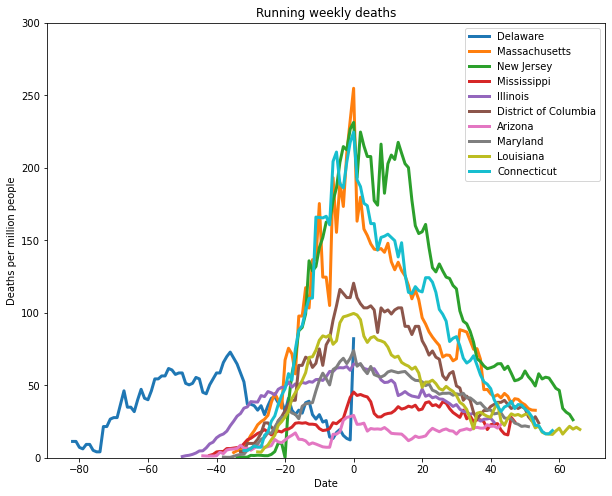

In [222]:
AREAS_OF_INTEREST = [
    ('US', 'NYC', 36, [5, 47, 61, 81, 85]),
    ('US', 'New Orleans', 22, [51, 71, 75, 87, 89, 95, 103, 105]),
    ('US', 'Detroit', 26, [87, 93, 99, 125, 147, 163]),
    ('US', 'Bay Area, CA', 6, [1, 13, 41, 55, 75, 81, 85, 95, 97]),
    ('US', 'Greater LA Area, CA', 6, [37, 59, 65, 71, 111]),
    ('US', 'Chicago', 17, [31, 37, 43, 63, 89, 91, 93, 111, 197]),
    ('US', 'Houston', 48, [15, 39, 71, 157, 167, 201, 291, 339, 473]),
    ('US', 'Austin', 48, [209, 453, 491]),
    ('US', 'Miami', 12, [11, 86, 99]),
    ('US', 'Tampa-St. Petersburg', 12, [53, 57, 101, 103]),
    #('US', 'Tulsa, Oklahoma', 40, [113, 131, 143, 145]),
]

# Highest weekly deaths
AREAS_OF_INTEREST = [
('US', 'Delaware', 10, []),
('US', 'Massachusetts', 25, []),
('US', 'New Jersey', 34, []),
('US', 'Mississippi', 28, []),
('US', 'Illinois', 17, []),
('US', 'District of Columbia', 11, []),
('US', 'Arizona', 4, []),
('US', 'Maryland', 24, []),
('US', 'Louisiana', 22, []),
('US', 'Connecticut', 9, []),
]

MODEL_FIT_LAST_DATE = datetime(2020, 6, 23)  # Fit model to data before this date, reserving later dates as holdout.
MODEL_FIT_FIRST_DATE = MODEL_FIT_LAST_DATE - timedelta(110)#'2020-04-25'
METRIC = 'Deaths'
pop_frac = 0.01
plt.figure(figsize=(10, 8))

# METRIC = 'Cases'
# pop_frac = 0.25
for AREA_OF_INTEREST in AREAS_OF_INTEREST:
    if len(AREA_OF_INTEREST) <= 2:
        area_df, population = datastore.get_time_series_for_area(AREA_OF_INTEREST[0])
    else:
        area_df, population = datastore.get_time_series_for_area(
            AREA_OF_INTEREST[0], AREA_OF_INTEREST[2], AREA_OF_INTEREST[3])

    area_df = area_df[['Date', METRIC]]
    train_area_df = area_df[
        (area_df.Date >= MODEL_FIT_FIRST_DATE) & 
        (area_df.Date <= MODEL_FIT_LAST_DATE)][['Date', METRIC]]
    train_area_df = train_area_df[train_area_df[METRIC] > 0]
    train_area_df = train_area_df.sort_values(by=['Date']).reset_index(drop=True)
    plot_df = (train_area_df[METRIC] - train_area_df[METRIC].shift(7)) / population * 1000000
    max_index = plot_df.argmax()
    print(max_index, plot_df[max_index])
    max_date = train_area_df[METRIC].max()
    # Validate selection through plot and inspection
    plt.plot(plot_df.index - max_index, plot_df, label=AREA_OF_INTEREST[1], linewidth=3)
plt.ylim((0,300))
#plt.yscale('log')
plt.legend()
plt.title('Running weekly deaths')
plt.ylabel('Deaths per million people')
plt.xlabel('Date')

# Load model params dataframe

In [4]:
model_df = pd.read_csv('data/states.csv', index_col='Unnamed: 0', parse_dates=['Date'])
model_df

,Date,Area,Deaths to Infections Ratio,Max Deaths,Current Herd Immunity,Final Herd Immunity,Infection Rate,Days To Recover,Deaths Multiplier,Frac Infected,R0,R,MSE
0,2020-05-01,Alabama,0.01,49031.85,0.005735,0.083872,0.104412,10.0,0.946834,0.990000,1.044116,1.038128,1.775327e+01
1,2020-05-02,Alabama,0.01,49031.85,0.005972,0.078099,0.103720,10.0,1.004316,0.956939,1.037203,1.031010,1.796360e+01
2,2020-05-03,Alabama,0.01,49031.85,0.005802,0.036894,0.097176,10.0,1.003336,0.990000,0.971755,0.966117,1.651641e+01
3,2020-05-04,Alabama,0.01,49031.85,0.005993,0.021275,0.090359,10.0,0.986371,0.990000,0.903591,0.898176,1.867493e+01
4,2020-05-05,Alabama,0.01,49031.85,0.006417,0.021901,0.090325,10.0,1.035654,0.956879,0.903247,0.897451,1.440133e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,2020-05-19,Wyoming,0.01,5787.59,0.000173,0.000173,0.001000,10.0,0.999944,0.010000,0.010000,0.009998,6.704975e-10
1121,2020-05-20,Wyoming,0.01,5787.59,0.000173,0.000173,0.001000,10.0,0.999944,0.010000,0.010000,0.009998,6.704975e-10
1122,2020-05-21,Wyoming,0.01,5787.59,0.000173,0.000173,0.001000,10.0,0.999944,0.010000,0.010000,0.009998,6.704975e-10
1123,2020-05-22,Wyoming,0.01,5787.59,0.000173,0.000173,0.001000,10.0,0.999944,0.010000,0.010000,0.009998,6.704975e-10


In [ ]:
# What are the best points to ignore? Use a median filter and threshold
sample_df = model_df[model_df['Area'] == 'Los Angeles']['Frac Infected']
sample_np = sample_df.to_numpy()

plt.figure(figsize=(15,10))
plt.plot(sample_np, label='raw', linewidth=4)
plt.plot(ndimage.maximum_filter(sample_np, 5)[2:], label='max filter')
plt.plot(signal.medfilt(sample_np, 5), label='median filter')
plt.plot(ndimage.gaussian_filter1d(sample_np, 2), label='gaussian kernel')
plt.legend()

logistic_coef = np.polyfit(np.arange(len(sample_np)), np.log(sample_np / (1 - sample_np)), deg=1)

logistic_fit = 1 / (1 + np.exp(-logistic_coef[1] * np.arange(len(sample_np)) - logistic_coef[0]))
plt.plot(logistic_fit)
# Gaussian kernel probably looks best?

In [ ]:
DATE_OFFSET = -20
plt.figure(figsize=(15, 8))
for area_name in model_df['Area'].unique():
    # Remove outliers
    area_df = model_df[(model_df['Area'] == area_name) & (model_df['Date'] >= '2020-04-15')]
    min_frac, max_frac = area_df.quantile(0.1)['Frac Infected'], area_df.quantile(0.9)['Frac Infected']
    max_mse = area_df.quantile(0.9)['MSE']
    print(area_name, min_frac, max_frac)
    filtered_df = area_df[(area_df['Frac Infected'] >= min_frac) & 
                          (area_df['Frac Infected'] <= max_frac) &
                          (area_df['MSE'] <= max_mse)]

    r_np = filtered_df[['Date', 'R']].to_numpy()

    ts = [mktime((x + timedelta(DATE_OFFSET)).timetuple()) for x in r_np[:,0]]
    min_ts = ts[0]
    max_ts = ts[-1]
    # Gaussian kernel smoothing
    y_fit = ndimage.gaussian_filter1d(np.log(r_np[:,1].astype(float)), 1)

    xnew = np.linspace(min_ts, max_ts, 100)

    spl = make_interp_spline(ts, y_fit, k=2)  # type: BSpline
    power_smooth = spl(xnew)
    xnew = [datetime.utcfromtimestamp(x) for x in xnew]
    #plt.scatter(r_np[:,0] + timedelta(DATE_OFFSET), r_np[:,1], label=area_name + ' raw R')
    plt.plot(xnew, np.exp(power_smooth), linewidth=4, label=area_name + ' smoothed R')
plt.plot(r_np[:,0] + timedelta(DATE_OFFSET), [1.0] * r_np.shape[0],
            linewidth=4, linestyle=':', c='k', label='R = 1')
plt.title('R values')
plt.legend()
plt.show()


In [ ]:
filtered_df = area_df[(area_df['Frac Infected'] >= min_frac) & 
                      (area_df['Frac Infected'] <= max_frac) &
                      (area_df['MSE'] <= max_mse)]

for area_name in model_df['Area'].unique():

    plt.figure(figsize=(15, 8))
    area_df = model_df[(model_df['Area'] == area_name) & (model_df['Date'] >= '2020-04-15')]
    min_frac, max_frac = area_df.quantile(0.05)['Frac Infected'], area_df.quantile(0.95)['Frac Infected']
    max_mse = area_df.quantile(0.9)['MSE']
    filtered_df = area_df[(area_df['Frac Infected'] >= min_frac) & 
                          (area_df['Frac Infected'] <= max_frac) &
                          (area_df['MSE'] <= max_mse)]
    r_np = filtered_df[['Date', 'R']].to_numpy()
    r_np_unfiltered = area_df[['Date', 'R']].to_numpy()
#     plt.scatter(r_np_unfiltered[:,0] + timedelta(DATE_OFFSET), r_np_unfiltered[:,1], linewidth=4, label=area_name + ' R raw')
#     plt.scatter(r_np_unfiltered[:,0] + timedelta(DATE_OFFSET), [1.0] * r_np_unfiltered.shape[0], linewidth=4, linestyle=':', label='R = 1')

    # 300 represents number of points to make between T.min and T.max
    ts = [mktime((x + timedelta(DATE_OFFSET)).timetuple()) for x in r_np[:,0]]
    min_ts = ts[0]
    max_ts = ts[-1]

    y_fit = ndimage.gaussian_filter1d(np.log(r_np[:,1].astype(float)), 1)

    xnew = np.linspace(min_ts, max_ts, 100)

    spl = make_interp_spline(ts, y_fit, k=2)  # type: BSpline
    power_smooth = spl(xnew)
    xnew = [datetime.utcfromtimestamp(x) for x in xnew]
    plt.plot(xnew, np.exp(power_smooth), linewidth=4, label=area_name + ' R filtered')
    # plt.plot(r_np[:,0] + timedelta(DATE_OFFSET), r_np[:,1], linewidth=4, label=area_name + ' filtered')
    plt.title('R values')
    plt.legend()
    plt.show()



In [ ]:
DATE_OFFSET = -17
area_names = model_df['Area'].unique()
plt.figure(figsize=(15, 8))
for area_name in area_names:
    r_np = model_df[model_df['Area'] == area_name][['Date', 'R']].to_numpy()
    plt.plot(r_np[:,0] + timedelta(DATE_OFFSET), r_np[:,1], linewidth=4, label=area_name)
plt.plot(r_np[:,0] + timedelta(DATE_OFFSET), [1.0] * r_np.shape[0], linewidth=4, linestyle=':')
plt.title('R values')
plt.legend()

In [ ]:
model_df[model_df['Area'] == 'New Orleans'].mean()

## Sheltering in place effect on infection rate

How many people does an infected person infect per day? Models trained with new data may reveal a sudden change in this parameter based on sheltering-in-place orders. For example, New York, Michigan, and Louisiana all implement sheltering-in-place orders around 3/22-3/24, and the "infection rate" based on deaths suddenly dropped about a week later.

In [ ]:
plt.figure(figsize=(10, 8))

shelter_dates_7_days = {'NYC': '2020-03-29',
                        'Detroit': '2020-03-31'
                       }

for area in ['NYC', 'Detroit', 'New Orleans']:
    model_area_df = model_df[model_df['Area'] == area]
    plt.plot(model_area_df['Date'], model_area_df['Infection Rate'], linewidth=5, label=area)
plt.legend()

## Anomaly detection

Can we use the model MSE to detect anomalies in the death rate?

Notice that there seems to be a recent sudden shift in prediction error around 4/15 for New Orleans, 4/16 for Detroit and New York! Why?

In [ ]:
for area in ['NYC', 'Detroit', 'New Orleans']:
    model_area_df = model_df[(model_df['Area'] == area) & (model_df['Date'] <= '2020-04-18')]
    plt.plot(model_area_df['Date'], model_area_df['MSE'], linewidth=5, label=area)
    plt.legend()
    plt.show()


In [ ]:
# Check data for one such area and date range
model_df[(model_df['Area'] == 'New Orleans') & (model_df['Date'] >= '2020-04-12') & (model_df['Date'] <= '2020-04-18')]

## Custom plots

What is the fraction of countries with Coronavirus cases?

In [ ]:
countries = [
    ('Italy', 'Italy'),
    ('Spain', 'Spain'),
    ('United Kingdom', 'United Kingdom'),
    ('US', 'US'),
    ('Germany', 'Germany'),
    ('Brazil', 'Brazil'),
    ('India', 'India'),
    ('Canada', 'Canada')
]
METRIC = 'Deaths'

plt.figure(figsize=(15,10))
for AREA_OF_INTEREST in countries:
    if len(AREA_OF_INTEREST) <= 2:
        area_df, population = datastore.get_time_series_for_area(AREA_OF_INTEREST[0])
    else:
        area_df, population = datastore.get_time_series_for_area(
            AREA_OF_INTEREST[0], AREA_OF_INTEREST[2], AREA_OF_INTEREST[3])

    plt.plot(area_df['Date'], area_df[METRIC] / population * 100, label=AREA_OF_INTEREST[0], linewidth=4)
plt.title('% ' + METRIC + ' / Population')
plt.xlabel('Date')
plt.ylabel('% of population')
plt.legend()

In [ ]:
plt.figure(figsize=(15,10))
for AREA_OF_INTEREST in countries:
    if len(AREA_OF_INTEREST) <= 2:
        area_df, population = datastore.get_time_series_for_area(AREA_OF_INTEREST[0])
    else:
        area_df, population = datastore.get_time_series_for_area(
            AREA_OF_INTEREST[0], AREA_OF_INTEREST[2], AREA_OF_INTEREST[3])

    plt.plot(area_df['Date'], area_df['Deaths'] / area_df['Cases'] * 100, label=AREA_OF_INTEREST[0], linewidth=4)
plt.title('Case fatality rate')
plt.xlabel('Date')
plt.ylabel('% deaths / cases')
plt.legend()

# Day of week reporting trends

The [US reporting trend](https://www.worldometers.info/coronavirus/country/us/) seems to indicate that Sundays have the lowest number of reported deaths, followed by Mondays. Both of these values are pretty significant. What can we do to denoise these measurements?

In [ ]:
# Sum up past 4 weeks
DAYS_OF_THE_WEEK = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

AREA_OF_INTEREST = ('US', 'New York', 36, [])
if len(AREA_OF_INTEREST) <= 2:
    area_df, population = datastore.get_time_series_for_area(AREA_OF_INTEREST[0])
else:
    area_df, population = datastore.get_time_series_for_area(
        AREA_OF_INTEREST[0], AREA_OF_INTEREST[2], AREA_OF_INTEREST[3])
    
area_df['dow'] = area_df['Date'].dt.dayofweek  # 0 is Monday, 6 is Sunday
#area_df['Cases'] = area_df['Cases'] - area_df['Cases'].shift(1)
area_df['Deaths'] = area_df['Deaths'] - area_df['Deaths'].shift(1)
area_df['Deaths Squared'] = area_df['Deaths'] * area_df['Deaths']

dow_sum = None
weeks = 5

weekly_sum = 0
weekly_sum_squared = 0
for days_before in range(weeks*7-1, weeks*7+6): #7 days shift
    for week in range(weeks):
        start_date = area_df['Date'].max() + timedelta(-days_before+week*7)
        norm_dow = area_df[
            (area_df['Date'] >= start_date) &
            (area_df['Date'] <= start_date + timedelta(6))
        ].groupby('dow').sum()
        dow_mean = norm_dow['Deaths'].mean()
        norm_dow['Deaths'] /= dow_mean
        norm_dow['Deaths Squared'] /= (dow_mean ** 2)
        weekly_sum += norm_dow['Deaths'].sum()
        weekly_sum_squared += norm_dow['Deaths Squared'].sum()
        if dow_sum is None: # 1 week of data
            dow_sum = norm_dow
        else:
            dow_sum += norm_dow
# Total number of samples is weeks * 7, so we take the mean by dividing by weeks * 7
death_mean = dow_sum['Deaths'] / weeks / 7
death_err = np.sqrt(dow_sum['Deaths Squared'] / weeks / 7 - death_mean * death_mean) / np.sqrt(weeks)
weekly_mean = weekly_sum / weeks / 7 / 7
weekly_err = np.sqrt(weekly_sum_squared / weeks / 7 / 7 - weekly_mean * weekly_mean) / np.sqrt(weeks)
kf_mean = (death_mean * (1 / death_err ** 2) + weekly_mean * (1 / weekly_err ** 2)
                         ) / ((1 / death_err ** 2) + (1 / weekly_err ** 2))
kf_err = np.sqrt(1 / ((1 / death_err ** 2) + (1 / weekly_err ** 2)))
print(weekly_mean, weekly_err)
print('Means of deaths', death_mean)
print('Kalman filtered', (death_mean * (1 / death_err ** 2) + weekly_mean * (1 / weekly_err ** 2)
                         ) / ((1 / death_err ** 2) + (1 / weekly_err ** 2)))

plt.bar(DAYS_OF_THE_WEEK, death_mean, yerr=death_err, capsize=7)
plt.title(AREA_OF_INTEREST[1] + ' detrended day-of-week deaths (' + str(weeks) + ' week average)')
plt.show()

plt.bar(DAYS_OF_THE_WEEK, kf_mean, yerr=kf_err, capsize=7)
plt.title(AREA_OF_INTEREST[1] + ' kalman filtered day-of-week deaths (' + str(weeks) + ' week average)')
plt.show()


In [ ]:
# Is this statistically significant? 



# Hospitalizations by state

In [10]:
HOSPITALIZATION_DIR = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'
hospitalization_df = None
for f in os.listdir(HOSPITALIZATION_DIR):
    file_date = f.split('.')[0]
    print(file_date)
    try:
        df = pd.read_csv(os.path.join(HOSPITALIZATION_DIR, f))
        df = df[['Province_State', 'FIPS', 'Confirmed', 'Deaths', 'People_Hospitalized']]
        df['Date'] = datetime.strptime(file_date, '%m-%d-%Y')
        if hospitalization_df is None:
            hospitalization_df = df
        else:
            hospitalization_df = hospitalization_df.append(df)
    except:
        continue
hospitalization_df = hospitalization_df.reset_index()

06-07-2020
06-06-2020
07-05-2020
07-04-2020
05-01-2020
05-23-2020
05-22-2020
06-10-2020
06-11-2020
04-21-2020
04-20-2020
07-12-2020
07-13-2020
05-29-2020
05-28-2020
04-15-2020
04-14-2020
05-17-2020
05-16-2020
06-24-2020
06-25-2020
05-24-2020
05-25-2020
06-17-2020
06-16-2020
04-18-2020
04-19-2020
06-29-2020
06-28-2020
04-26-2020
04-27-2020
07-14-2020
04-12-2020
04-13-2020
05-10-2020
05-11-2020
06-23-2020
06-22-2020
06-01-2020
04-30-2020
07-02-2020
07-03-2020
05-07-2020
05-06-2020
07-08-2020
07-09-2020
README
06-19-2020
06-18-2020
04-16-2020
04-17-2020
06-27-2020
06-26-2020
05-14-2020
05-15-2020
04-28-2020
04-29-2020
06-13-2020
06-12-2020
05-20-2020
05-21-2020
07-11-2020
07-10-2020
04-22-2020
04-23-2020
06-30-2020
05-03-2020
05-02-2020
06-04-2020
06-05-2020
05-09-2020
05-08-2020
07-06-2020
07-07-2020
06-09-2020
06-08-2020
05-04-2020
05-05-2020
06-03-2020
06-02-2020
05-30-2020
05-31-2020
07-01-2020
06-20-2020
06-21-2020
05-13-2020
05-12-2020
06-14-2020
06-15-2020
05-27-2020
05-26-2020
05-

In [11]:
print(hospitalization_df[(hospitalization_df['Date'] == '2020-06-20')
                   & (hospitalization_df['People_Hospitalized'].isna())]['Province_State'].tolist())

['Alaska', 'American Samoa', 'California', 'Delaware', 'Diamond Princess', 'District of Columbia', 'Grand Princess', 'Guam', 'Illinois', 'Iowa', 'Louisiana', 'Michigan', 'Missouri', 'Nevada', 'North Carolina', 'Northern Mariana Islands', 'Pennsylvania', 'Puerto Rico', 'Texas', 'Vermont', 'Virgin Islands', 'West Virginia']


,index,Province_State,FIPS,Confirmed,Deaths,People_Hospitalized,Date
1868,4,California,6.0,22795,640,5234.0,2020-04-12
1928,5,California,6.0,23931,714,3015.0,2020-04-13
936,5,California,6.0,25356,767,5163.0,2020-04-14
877,5,California,6.0,26686,860,5163.0,2020-04-15
2799,5,California,6.0,27677,956,5031.0,2020-04-16
...,...,...,...,...,...,...,...
3557,5,California,6.0,310885,6955,NaN,2020-07-10
3499,5,California,6.0,318761,7027,NaN,2020-07-11
645,5,California,6.0,324543,7051,NaN,2020-07-12
703,5,California,6.0,333357,7089,NaN,2020-07-13


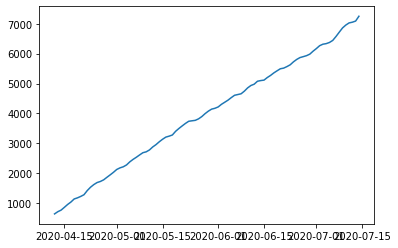

In [5]:
sample_df = hospitalization_df[
    (hospitalization_df['Province_State'] == 'California')].sort_values('Date')

plt.plot(sample_df['Date'], sample_df['Deaths'])
sample_df

In [6]:
# California only

california_df = pd.read_csv('./data_repo/california_covid19data.csv')
california_df['Date'] = california_df['Most Recent Date'].apply(lambda d: datetime.strptime(d, '%m/%d/%Y'))
california_df

,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,Date
0,Los Angeles,4/1/2020,3502.0,66.0,739.0,1332.0,335.0,220.0,2020-04-01
1,San Bernardino,4/1/2020,245.0,5.0,95.0,196.0,39.0,52.0,2020-04-01
2,Orange,4/1/2020,579.0,11.0,117.0,221.0,50.0,48.0,2020-04-01
3,Riverside,4/1/2020,306.0,11.0,85.0,182.0,29.0,47.0,2020-04-01
4,Sacramento,4/1/2020,299.0,8.0,53.0,138.0,20.0,33.0,2020-04-01
...,...,...,...,...,...,...,...,...,...
4950,Tuolumne,06/23/2020,9.0,0.0,1.0,0.0,0.0,0.0,2020-06-23
4951,Unassigned,06/23/2020,3.0,0.0,0.0,0.0,0.0,0.0,2020-06-23
4952,Ventura,06/23/2020,2209.0,43.0,54.0,40.0,14.0,9.0,2020-06-23
4953,Yolo,06/23/2020,350.0,24.0,1.0,0.0,1.0,0.0,2020-06-23


In [7]:
california_statewide_df = california_df.groupby('Date').sum().sort_index()

Text(0, 0.5, 'Hospitalizations')

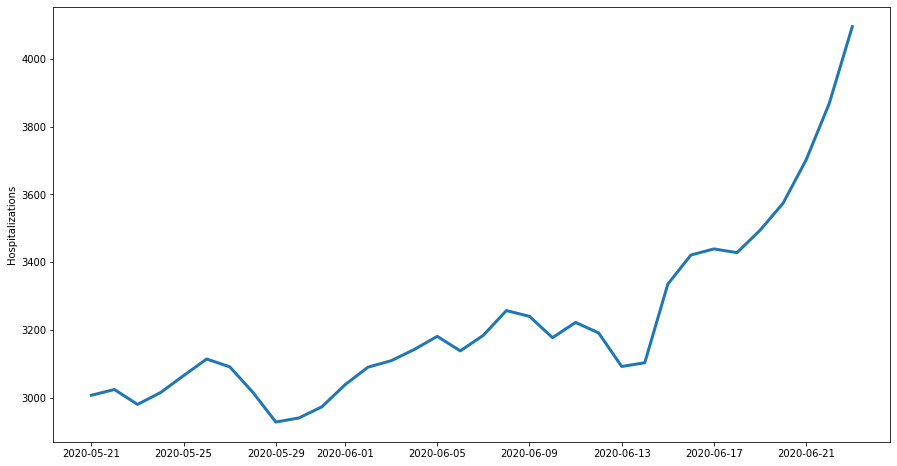

In [9]:
plt.figure(figsize=(15,8))
plt.plot(california_statewide_df.index[50:], california_statewide_df['COVID-19 Positive Patients'][50:],
         linewidth=3)
plt.ylabel('Hospitalizations')

In [12]:
sample_df = sample_df.set_index('Date')

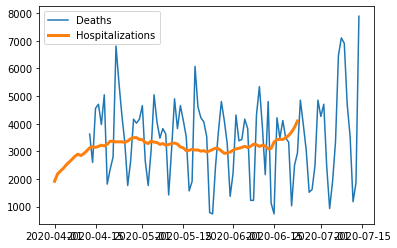

In [13]:
plt.plot((sample_df['Deaths'] - sample_df['Deaths'].shift(1)) * 49, label='Deaths')
plt.plot(california_statewide_df.index, california_statewide_df['COVID-19 Positive Patients'],
         linewidth=3, label='Hospitalizations')
plt.legend()

In [198]:
np_weekly_deaths = (sample_df['Deaths'] - sample_df['Deaths'].shift(1)).to_numpy()[1:]

In [199]:
np_hosp = california_statewide_df['COVID-19 Positive Patients'].to_numpy()

72 84
4 46.65262735659847


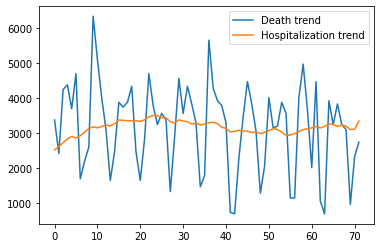

In [207]:
min_mse = 1e12
min_scalar = 0
min_index = -1
print(np_weekly_deaths.shape[0], np_hosp.shape[0])
for i in range(np_hosp.shape[0] - np_weekly_deaths.shape[0]):
    scalar = np.mean(np_hosp[i:i+np_weekly_deaths.shape[0]]) / np.mean(np_weekly_deaths)
    mse = np.mean(np.square(np_hosp[i:i+np_weekly_deaths.shape[0]] - scalar * np_weekly_deaths))
    if mse < min_mse:
        min_index = i
        min_scalar = scalar
        min_mse = mse
plt.plot(min_scalar * np_weekly_deaths, label='Death trend')
plt.plot(np_hosp[min_index:min_index+np_weekly_deaths.shape[0]], label='Hospitalization trend')
plt.legend()
print(min_index, scalar)

# Overlaying curves on top of each other

Timestamp('2020-06-23 00:00:00')